---------------------


-- _CODE IN PROGRESS_ --


---------------------

<a href="http://www.road2quant.com">
    <img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" target="_blank" align="right" border="0" width="35%" >
</a>

# Intro to Machine Learning Based Strategies

This work aims to create and test investment strategies based on machine learning (ML) techniques. In this case, the forecasts are based on the Microsoft stock price and returns. We use regression techniques (predicting exact numbers) and classification techniques.

## Importing the required libraries

First, we begin by importing the libraries we used across the code. 
- `Yfinance` to download the daily prices from yahoo finance.
- `Numpy` and `Pandas` to manipulate the data.
- `Matplotlib` and `Seaborn` to create the charts
- `Scikit-learn` to implement machine learning models

In [34]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn import linear_model

### Graph Formating

In [4]:
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'
%matplotlib inline

SMALL_SIZE = 14; MEDIUM_SIZE = 16; BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(10,6))         # size fo the graph

## Downloading the Data

The next step is to download the Microsoft (MSFT) historical price from Yahoo Finance. The window used is daily data from Jan-2010 to Dec-2019.

In [35]:
symbol = ["MSFT"]
rawdata = yf.download(symbol, start="2010-01-01", end="2019-12-31")
rawdata = pd.DataFrame(rawdata['Close'])
rawdata.columns = ['price']

[*********************100%***********************]  1 of 1 completed


To have a first insight into the data, we proceed to create a line chart with the downloaded price. We can tell that the stock has a positive trend across the nine years analyzed, and it seems to follow an exponential growth pattern.

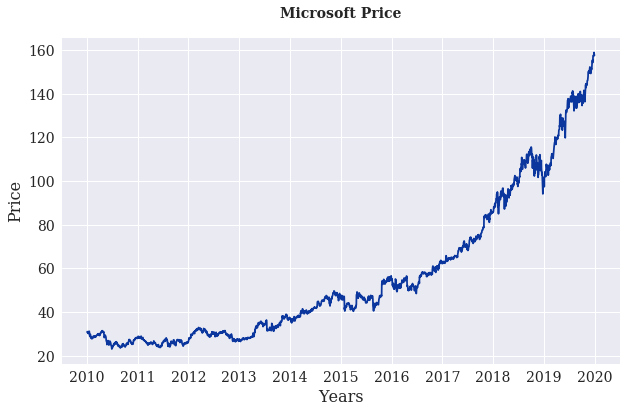

In [36]:
plt.figure()
plt.title('Microsoft Price',fontweight="bold", pad=20)
plt.xlabel('Years')
plt.ylabel('Price')
plt.plot(rawdata, color='#0A369D');
# plt.savefig('price.png', facecolor='None')

## Univariate Linear Regression Model

To begin with the predictions, we started by utilizing a simple linear regression model. In this example, we look for a relationship between the MSFT price and the time variable. As a result of the visual inspection, we created a two-degree linear model that emulates the exponential growth that we mentioned before.

At the moment of forecasting, it is a good practice to split the data into training and test to validate the prediction with unknown inputs and not utilize the same ones that we used to create the model.

In [40]:
LR = rawdata.copy()
LR['indx'] = np.arange(len(LR))

split = int(len(LR) * 0.8)
LR_train, LR_test = LR[:split], LR[split:]

X_test  = LR_test['indx'].values
X_train = LR_train['indx'].values
y_train = LR_train['price'].values

reg = np.polyfit(X_train, y_train, deg=2)
reg.round(2)

array([ 0.000e+00, -1.000e-02,  2.802e+01])

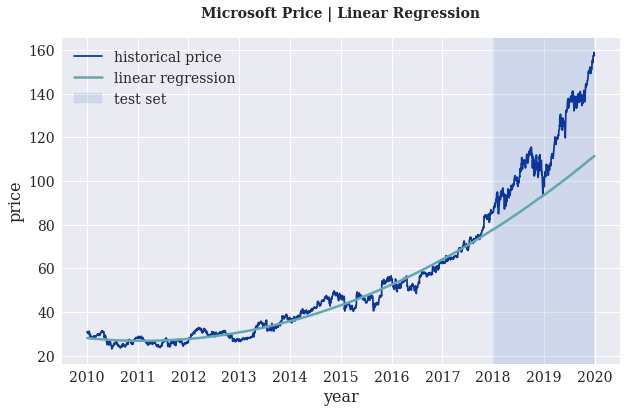

In [39]:
fig = plt.figure()
ax = plt.axes()
ax.plot(LR.index,LR['price'],label='historical price', color='#0A369D')
ax.plot(LR.index, np.polyval(reg, LR['indx']), lw=2.5,
         label='linear regression', color='#62a8ac')
ax.axvspan(LR.index[split], LR.index[len(LR)-1], alpha=0.25, color='#80A1D4', label='test set')
ax.set_title('Microsoft Price | Linear Regression',fontweight="bold", pad=20)
ax.set_xlabel('year')
ax.set_ylabel('price')
plt.legend(loc=0);
# plt.savefig('price_regression.png', facecolor='None')

## Multivariate Linear Regression Model (price prediction)

In [9]:
lags = 5
cols = []
lagsR = rawdata.copy()

for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    lagsR[col] = lagsR['price'].shift(lag)
    cols.append(col)
lagsR.dropna(inplace=True)

In [10]:
lagsR.head()

,price,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-11,30.270000,30.660000,30.450001,30.770000,30.959999,30.950001
2010-01-12,30.070000,30.270000,30.660000,30.450001,30.770000,30.959999
2010-01-13,30.350000,30.070000,30.270000,30.660000,30.450001,30.770000
2010-01-14,30.959999,30.350000,30.070000,30.270000,30.660000,30.450001
2010-01-15,30.860001,30.959999,30.350000,30.070000,30.270000,30.660000


In [11]:
a = lagsR[cols].corr()
a.round(3)

,lag_1,lag_2,lag_3,lag_4,lag_5
lag_1,1.000,1.000,0.999,0.999,0.999
lag_2,1.000,1.000,1.000,0.999,0.999
lag_3,0.999,1.000,1.000,1.000,0.999
lag_4,0.999,0.999,1.000,1.000,1.000
lag_5,0.999,0.999,0.999,1.000,1.000


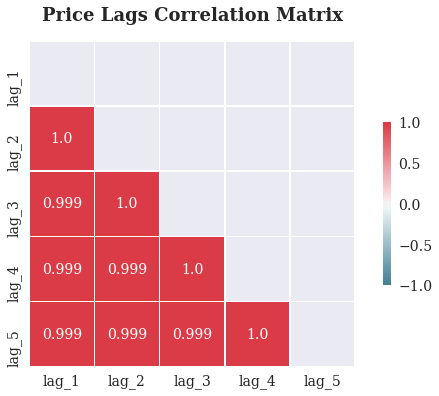

In [12]:
mask = np.triu(np.ones_like(a, dtype=np.bool))
f, ax = plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(a, mask=mask,  cmap=cmap,  annot=True,fmt=".3", vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Price Lags Correlation Matrix',fontsize=18,fontweight="bold", pad=20);
# plt.savefig('price_corr.png', facecolor='None')

In [13]:
reg = np.linalg.lstsq(lagsR[cols], lagsR['price'],
                      rcond=None)[0]

In [14]:
lagsR['prediction'] = np.dot(lagsR[cols], reg)

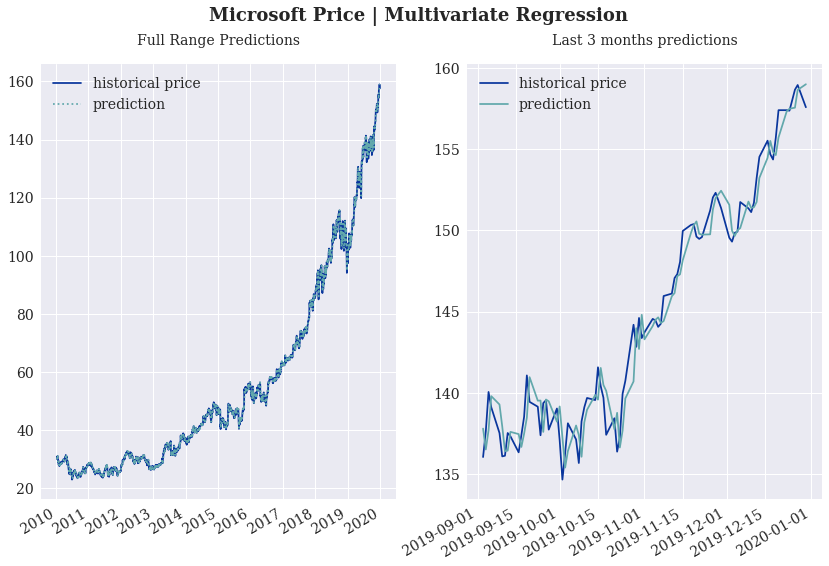

In [15]:
plt.figure(figsize=(14, 8))

plt.subplot(1,2,1)
plt.plot(lagsR.index, lagsR['price'], label='historical price', color='#0A369D')
plt.plot(lagsR.index, lagsR['prediction'], label='prediction', linestyle=':', color='#62a8ac')
plt.title('Full Range Predictions', pad=20)
plt.legend(loc=0)
plt.setp(plt.xticks()[1], rotation=30, ha='right');

plt.subplot(1,2,2)
plt.plot(lagsR.loc['2019-9-1':].index, lagsR['price'].loc['2019-9-1':],
         label='historical price', color='#0A369D')
plt.plot(lagsR.loc['2019-9-1':].index, lagsR['prediction'].loc['2019-9-1':],
         label='prediction', linestyle='-', color='#62a8ac')
plt.title('Last 3 months predictions', pad=20)
plt.legend(loc=0)
plt.setp(plt.xticks()[1], rotation=30, ha='right')
plt.suptitle("Microsoft Price | Multivariate Regression",fontweight="bold");
# plt.savefig('price_multi.png', facecolor='None')

## Multivariate Linear Regression Model (return prediction)

In [16]:
rets = rawdata.copy()
rets['returns'] = np.log(rets/rets.shift(1))

lags = 5
cols = []

for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    rets[col] = rets['returns'].shift(lag)
    cols.append(col)
rets.dropna(inplace=True)

rets.head()

,price,returns,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,
2010-01-12,30.070000,-0.006629,-0.012802,0.006873,-0.010454,-0.006156,0.000323
2010-01-13,30.350000,0.009269,-0.006629,-0.012802,0.006873,-0.010454,-0.006156
2010-01-14,30.959999,0.019899,0.009269,-0.006629,-0.012802,0.006873,-0.010454
2010-01-15,30.860001,-0.003235,0.019899,0.009269,-0.006629,-0.012802,0.006873
2010-01-19,31.100000,0.007747,-0.003235,0.019899,0.009269,-0.006629,-0.012802


In [17]:
b = rets[cols].corr()
b.round(3)

,lag_1,lag_2,lag_3,lag_4,lag_5
lag_1,1.000,-0.035,-0.022,0.005,-0.037
lag_2,-0.035,1.000,-0.035,-0.022,0.005
lag_3,-0.022,-0.035,1.000,-0.035,-0.022
lag_4,0.005,-0.022,-0.035,1.000,-0.035
lag_5,-0.037,0.005,-0.022,-0.035,1.000


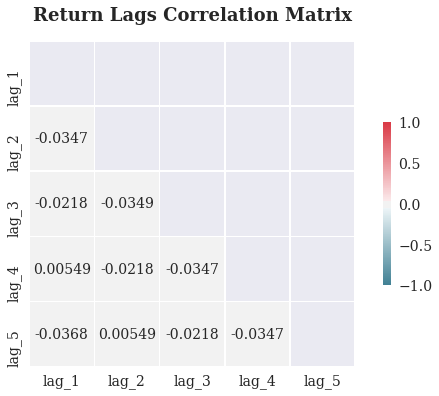

In [18]:
mask = np.triu(np.ones_like(b, dtype=np.bool))
f, ax = plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(b, mask=mask, cmap=cmap ,  annot=True ,fmt=".3",vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Return Lags Correlation Matrix',fontsize=18,fontweight="bold", pad=20);
# plt.savefig('returns_corr.png', facecolor='None')

In [19]:
reg = np.linalg.lstsq(rets[cols], rets['returns'],
                      rcond=None)[0]
reg

array([-0.03467407, -0.02135581,  0.00374165, -0.03650272, -0.05466607])

In [20]:
rets['prediction'] = np.dot(rets[cols], reg)

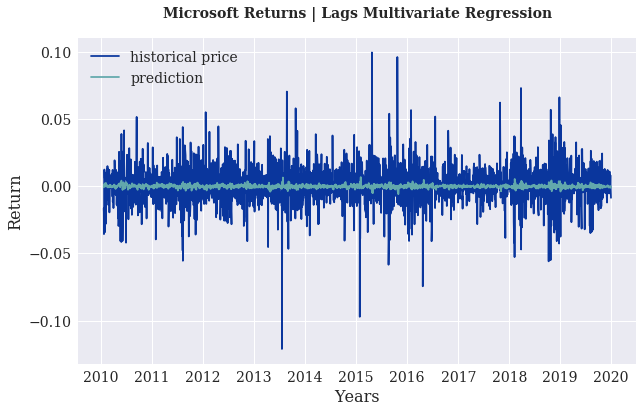

In [21]:
plt.figure()
plt.title('Microsoft Returns | Lags Multivariate Regression',fontweight="bold", pad=20)
plt.xlabel('Years')
plt.ylabel('Return')
plt.plot(rets['returns'].iloc[lags:], label='historical price', color='#0A369D')
plt.plot(rets['prediction'].iloc[lags:], label='prediction', color='#62a8ac')
plt.legend(loc=0);
# plt.savefig('returns_multi.png', facecolor='None')

In [22]:
cutoff = '2018-1-1'
train = rets[rets.index < cutoff].copy()
test = rets[rets.index >= cutoff].copy()

In [23]:
reg = np.linalg.lstsq(train[cols], train['returns'],
                      rcond=None)[0]
reg

array([ 0.00177352,  0.01168872, -0.02328992, -0.03026865, -0.03686199])

In [24]:
test['prediction'] = np.dot(test[cols], reg)

In [25]:
test['prediction'] = np.sign(test['prediction'])

In [26]:
hits = np.sign(test['returns'] *
               test['prediction']).value_counts()
hits

 1.0    260
-1.0    239
 0.0      3
dtype: int64

In [27]:
hits.values[0] / sum(hits)

0.5179282868525896

In [28]:
test['strategy'] = test['prediction'] * test['returns']

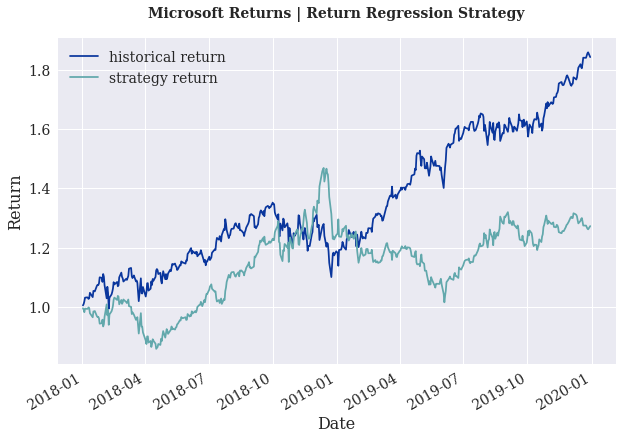

In [33]:
plt.figure()
plt.title('Microsoft Returns | Return Regression Strategy',fontweight="bold", pad=20)
plt.xlabel('Date')
plt.ylabel('Return')
plt.plot(test['returns'].cumsum().apply(np.exp), label='historical return', color='#0A369D')
plt.plot(test['strategy'].cumsum().apply(np.exp), label='strategy return', color='#62a8ac')
plt.legend(loc=0)
plt.setp(plt.xticks()[1], rotation=30, ha='right');
# plt.savefig('regression_strategy.png', facecolor='None')

## Logistic Regression Model (return prediction)

In [28]:
cutoff = '2018-1-1'
train = rets[rets.index < cutoff].copy()
test = rets[rets.index >= cutoff].copy()

lm = linear_model.LogisticRegression(C=1e6, solver='lbfgs',
                                     multi_class='auto')
lm.fit(train[cols], np.sign(train['returns']))

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
test['prediction'] = lm.predict(test[cols])

In [30]:
test['prediction'].value_counts()

 1.0    346
-1.0    156
Name: prediction, dtype: int64

In [31]:
hits = np.sign(test['returns'].iloc[lags:] *
               test['prediction'].iloc[lags:]
              ).value_counts()
hits

 1.0    273
-1.0    221
 0.0      3
dtype: int64

In [32]:
accuracy_score(test['prediction'],
               np.sign(test['returns']))

0.5537848605577689

In [33]:
test['strategy'] = test['prediction'] * test['returns']

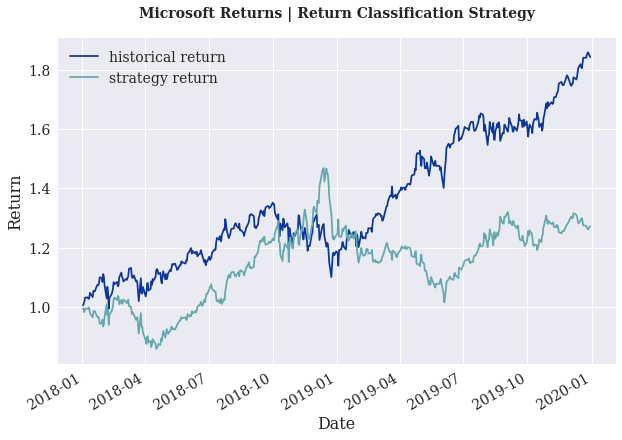

In [32]:
# test[['returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

plt.figure()
plt.title('Microsoft Returns | Return Classification Strategy',fontweight="bold", pad=20)
plt.xlabel('Date')
plt.ylabel('Return')
plt.plot(test['returns'].cumsum().apply(np.exp), label='historical return', color='#0A369D')
plt.plot(test['strategy'].cumsum().apply(np.exp), label='strategy return', color='#62a8ac')
plt.legend(loc=0)
plt.setp(plt.xticks()[1], rotation=30, ha='right');
# plt.savefig('classification_strategy.png', facecolor='None')

## Conclusion

## References

Inspired by the book *Artificial Intelligence for Finance* by Yves Hilpisch.

<img src="https://images-na.ssl-images-amazon.com/images/I/51VEL0RZbzL._SX379_BO1,204,203,200_.jpg" width="250" style="float:left">

and the *University Certificate in Python for Algorithmic Trading*

<img src="https://home.tpq.io/wp-content/uploads/2019/11/algo_broch_cov_shadow.png" width="250" style="float:left">

<a href="http://www.road2quant.com">
    <img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" target="_blank" align="right" border="0" width="35%" >
</a>